# Package

In [59]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os

# Data augmentation

Reprojectioning: 
1. climate precipitation
2. gridded population density
3. land cover

to GPP.

In [ ]:
with rasterio.open('Datasets_Hackathon/MODIS_Gross_Primary_Production_GPP/2010_GP.tif') as src_GPP:
    with rasterio.open('Datasets_Hackathon/Climate_Precipitation_Data/2010R.tif') as src_climate:
        
        # 2. Choose which dataset to use as the reference (target)
        # Usually you'd choose the higher resolution one
        # For this example, let's use landcover as the reference
        
        # Get the metadata from the reference file
        dst_crs = src_GPP.crs
        dst_transform = src_GPP.transform
        dst_height = src_GPP.height
        dst_width = src_GPP.width
        
        # 3. Create a destination array for the reprojected climate data
        dst_climate = np.zeros((dst_height, dst_width), dtype=rasterio.float32)
        
        # 4. Reproject the climate data to match the landcover data
        reproject(
            source=rasterio.band(src_climate, 1),
            destination=dst_climate,
            src_transform=src_climate.transform,
            src_crs=src_climate.crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear  # Choose appropriate resampling method
        )
        
        # 5. Now dst_climate and src_landcover.read(1) should be aligned
        GPP_data = src_GPP.read(1)
        
        # 6. Now you can extract and compare data for the same pixels
        # For example, to get pixel values at position (100, 100):
        gpp_value = GPP_data[100, 100]
        climate_value = dst_climate[100, 100]
        
        print(f"Land cover value: {gpp_value}")
        print(f"Climate value: {climate_value}")
        
        # 7. Optional: Save the reprojected climate data
        profile = src_GPP.profile.copy()
        profile.update(dtype=rasterio.float32, count=1)
        
        with rasterio.open('climate_reprojected.tif', 'w', **profile) as dst:
            dst.write(dst_climate, 1)

In [27]:
# Define years list
years = range(2010, 2023)

# Define input and output paths
data_path = 'Datasets_Hackathon'
output_path = 'Datasets_Hackathon/reprojected_data'  # Current directory, change as needed

# List of data categories with their appropriate resampling methods and filename formats
datasets = [
    {'name': 'MODIS_Gross_Primary_Production_GPP', 'file_format': '{year}_GP.tif', 'is_reference': True},
    {'name': 'Climate_Precipitation_Data', 'file_format': '{year}R.tif', 'resampling': Resampling.bilinear}, #Resampling.bilinear
    {'name': 'Modis_Land_Cover_Data', 'file_format': '{year}LCT.tif', 'resampling': Resampling.nearest},
    # {'name': 'Gridded_Population_Density_Data', 'file_format': 'Assaba_Pop_{year}.tif', 'resampling': Resampling.bilinear}
]

# Dictionary to store data for all years and all datasets
all_data = {}
for dataset in datasets:
    short_name = dataset['name'].split('_')[0].lower()
    all_data[short_name] = {}

# Loop through each year
for year in years:
    print(f"Processing data for year {year}...")
    
    # First, open the reference dataset (GPP)
    ref_dataset = next(d for d in datasets if d['is_reference'])
    ref_file = os.path.join(data_path, ref_dataset['name'], ref_dataset['file_format'].format(year=year))
    
    try:
        with rasterio.open(ref_file) as src_ref:
            # Get reference metadata
            dst_crs = src_ref.crs
            dst_transform = src_ref.transform
            dst_height = src_ref.height
            dst_width = src_ref.width
            
            # Read reference data (GPP)
            gpp_data = src_ref.read(1)
            all_data['modis'][year] = gpp_data
            
            # Store reference profile for output files
            profile = src_ref.profile.copy()
            profile.update(dtype=rasterio.float32, count=1)
            
            # Process each non-reference dataset
            for dataset in [d for d in datasets if not d.get('is_reference', False)]:
                dataset_name = dataset['name'].split('_')[0].lower()  # Extract short name
                
                # Construct input filename using the file format template
                input_file = os.path.join(data_path, dataset['name'], dataset['file_format'].format(year=year))
                output_file = os.path.join(output_path, f"{dataset_name}_reprojected_{year}.tif")
                
                # Create destination array
                dst_array = np.zeros((dst_height, dst_width), dtype=rasterio.float32)
                
                # Open and reproject
                try:
                    with rasterio.open(input_file) as src:
                        reproject(
                            source=rasterio.band(src, 1),
                            destination=dst_array,
                            src_transform=src.transform,
                            src_crs=src.crs,
                            dst_transform=dst_transform,
                            dst_crs=dst_crs,
                            resampling=dataset['resampling']
                        )
                        
                        # Store in all_data dictionary by year
                        all_data[dataset_name][year] = dst_array
                        
                        # Save reprojected data
                        with rasterio.open(output_file, 'w', **profile) as dst:
                            dst.write(dst_array, 1)
                            
                        print(f"Successfully reprojected and saved {output_file}")
                        
                except Exception as e:
                    print(f"Error processing {input_file}: {e}")
                    continue

    except Exception as e:
        print(f"Error processing year {year}: {e}")
        continue

Processing data for year 2010...
Successfully reprojected and saved Datasets_Hackathon/reprojected_data/climate_reprojected_2010.tif
Successfully reprojected and saved Datasets_Hackathon/reprojected_data/modis_reprojected_2010.tif
Processing data for year 2011...
Successfully reprojected and saved Datasets_Hackathon/reprojected_data/climate_reprojected_2011.tif
Successfully reprojected and saved Datasets_Hackathon/reprojected_data/modis_reprojected_2011.tif
Processing data for year 2012...
Successfully reprojected and saved Datasets_Hackathon/reprojected_data/climate_reprojected_2012.tif
Successfully reprojected and saved Datasets_Hackathon/reprojected_data/modis_reprojected_2012.tif
Processing data for year 2013...
Successfully reprojected and saved Datasets_Hackathon/reprojected_data/climate_reprojected_2013.tif
Successfully reprojected and saved Datasets_Hackathon/reprojected_data/modis_reprojected_2013.tif
Processing data for year 2014...
Successfully reprojected and saved Datasets

### training and testing arrays construction

In [28]:
# Create X and Y arrays for all years combined

# First, determine valid pixels across all datasets and years
valid_mask = np.ones((dst_height, dst_width), dtype=bool)
for dataset_name, years_data in all_data.items():
    for year, data in years_data.items():
        # Update mask for invalid values (assuming NaN or negative values are invalid)
        if np.issubdtype(data.dtype, np.floating):
            valid_mask = valid_mask & ~np.isnan(data)
        valid_mask = valid_mask & (data >= 0)

# Count how many valid samples we'll have
n_samples = np.sum(valid_mask)
print(f"Total valid samples across all years: {n_samples}")

# Create X (features) and Y (target) arrays
n_years = len(years)
n_features = len([d for d in datasets if not d.get('is_reference', False)])
X = np.zeros((n_samples * n_years, n_features))
Y = np.zeros(n_samples * n_years)

# Create a dataframe to store the data
columns = ['year', 'row', 'col', 'gpp']
for dataset in [d for d in datasets if not d.get('is_reference', False)]:
    short_name = dataset['name'].split('_')[0].lower()
    columns.append(short_name)

df = pd.DataFrame(columns=columns)

# Fill the dataframe
sample_idx = 0
for year_idx, year in enumerate(years):
    # Get valid coordinates
    rows, cols = np.where(valid_mask)
    
    # Temporary data for this year
    year_data = []
    
    for i in range(len(rows)):
        row, col = rows[i], cols[i]
        
        # Skip if any dataset has invalid data for this pixel in this year
        skip = False
        for dataset_name, years_data in all_data.items():
            if year not in years_data or np.isnan(years_data[year][row, col]):
                skip = True
                break
        if skip:
            continue
            
        # Create a row in the dataframe
        row_data = {
            'year': year,
            'row': row,
            'col': col,
            'gpp': all_data['modis'][year][row, col]
        }
        
        # Add feature data
        feature_idx = 0
        for dataset in [d for d in datasets if not d.get('is_reference', False)]:
            short_name = dataset['name'].split('_')[0].lower()
            row_data[short_name] = all_data[short_name][year][row, col]
            # Also add to X array
            X[sample_idx, feature_idx] = all_data[short_name][year][row, col]
            feature_idx += 1
        
        # Add to Y array
        Y[sample_idx] = all_data['modis'][year][row, col]
        
        # Add to temporary data
        year_data.append(row_data)
        
        sample_idx += 1
    
    # Add this year's data to the dataframe
    df = pd.concat([df, pd.DataFrame(year_data)], ignore_index=True)
    print(f"Added {len(year_data)} samples for year {year}")

# Trim excess rows if needed
if sample_idx < n_samples * n_years:
    X = X[:sample_idx, :]
    Y = Y[:sample_idx]
    print(f"Trimmed arrays to actual size: {sample_idx} samples")

# Save the prepared data
df.to_csv('all_data_prepared.csv', index=False)
np.save('X_features.npy', X)
np.save('Y_target.npy', Y)

print("Data preparation complete!")
print(f"Feature array shape: {X.shape}")
print(f"Target array shape: {Y.shape}")
print(f"CSV data shape: {df.shape}")


Total valid samples across all years: 163955
Added 163955 samples for year 2010
Added 163955 samples for year 2011
Added 163955 samples for year 2012
Added 163955 samples for year 2013
Added 163955 samples for year 2014
Added 163955 samples for year 2015
Added 163955 samples for year 2016
Added 163955 samples for year 2017
Added 163955 samples for year 2018
Added 163955 samples for year 2019
Added 163955 samples for year 2020
Added 163955 samples for year 2021
Added 163955 samples for year 2022
Data preparation complete!
Feature array shape: (2131415, 2)
Target array shape: (2131415,)
CSV data shape: (2131415, 6)


In [29]:
df

,year,row,col,gpp,climate,modis
0,2010,3,459,16.0,122.910858,16.0
1,2010,3,460,16.0,122.601082,16.0
2,2010,3,461,16.0,122.291298,16.0
3,2010,4,457,16.0,123.511665,16.0
4,2010,4,458,16.0,123.201889,16.0
...,...,...,...,...,...,...
2131410,2022,758,451,10.0,549.432678,10.0
2131411,2022,758,452,10.0,550.221802,10.0
2131412,2022,758,453,10.0,551.010925,10.0
2131413,2022,758,454,10.0,551.80011,10.0


# Modeling

In [ ]:
X = df[['climate', 'modis']].values
y = df['gpp'].values

In [49]:
y_categorical = y.astype('category')

In [55]:
X.loc[:, 'modis'] = X['modis'].astype('category')

/var/folders/cv/9q5q5y114zj360801_hx11rc0000gn/T/ipykernel_90854/1731800309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'modis'] = X['modis'].astype('category')


In [62]:
# Convert 'modis' into categorical using LabelEncoder
label_encoder = LabelEncoder()
X['modis'] = label_encoder.fit_transform(X['modis'])

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
accuracy = model.score(X_test, y_test)
print(f"Model R-squared (Accuracy) on test set: {accuracy}")

/var/folders/cv/9q5q5y114zj360801_hx11rc0000gn/T/ipykernel_90854/2011796791.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['modis'] = label_encoder.fit_transform(X['modis'])


Model R-squared (Accuracy) on test set: 0.9987221500825927


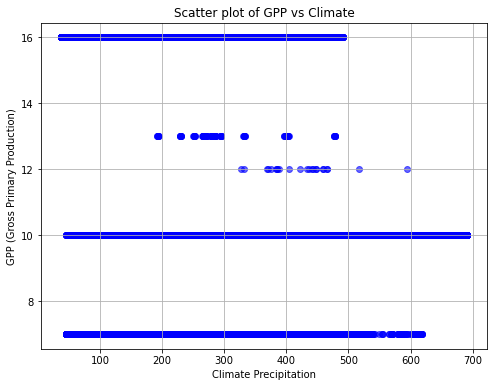

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Plotting y ('gpp') against the 'climate' feature
plt.scatter(X['climate'], y, alpha=0.6, color='b')
plt.title('Scatter plot of GPP vs Climate')
plt.xlabel('Climate Precipitation')
plt.ylabel('GPP (Gross Primary Production)')
plt.grid(True)
plt.show()